In [1]:
import math
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.animation as animation

In [2]:
@jit(nopython=True)
def solve1(uu, jj, nn, α):  # решение уравнения по явной схеме
    for n in range(nn - 1):
        for j in range(1, jj - 1):
            uu[j, n + 1] = uu[j, n] + α * (
                uu[j + 1, n] - 2 * uu[j, n] + uu[j - 1, n]
            )
    return uu

In [31]:
@jit(nopython=True)
def F(v, jj, s):  # функция, вычисляющая правую часть уравнения
    f = np.empty(jj, dtype=np.float64)
    f[0] = -v[1] + 2 * (1 - s) * v[0]
    f[jj - 1] = 2 * (1 - s) * v[jj - 1] - v[jj - 2]
    for j in range(1, jj - 1):
        f[j] = -v[j + 1] + 2 * (1 - s) * v[j] - v[j - 1]
    return f


@jit(nopython=True)
def progonka(v, jj, s):
    x = np.empty(jj, dtype=np.float64)  # массив для прямой прогонки
    y = np.empty(jj, dtype=np.float64)  # массив для прямой прогонки
    a_j = 1  # коэффициент перед u_j+1
    b_j = -2 * (1 + s)  # коэффициент перед u_j
    c_j = 1  # коэффициент перед u_j-1
    f = F(
        v, jj, s
    )  # вектор правой части неоднородной системы линейных уравнений

    x[jj - 1] = -c_j / b_j
    y[jj - 1] = f[jj - 1] / b_j

    for j in range(jj - 1, 0, -1):  # прямая прогонка
        x[j - 1] = -c_j / (b_j + a_j * x[j])
        y[j - 1] = (f[j] - a_j * y[j]) / (a_j * x[j] + b_j)

    v[0] = 0  # граничное условие
    tmp = np.empty(jj, dtype=np.float64)
    for j in range(0, jj - 2):  # обратная прогонка
        tmp[j + 1] = x[j] * v[j] + y[j]
    tmp[0] = 0
    tmp[jj - 1] = 0
    return tmp


@jit(nopython=True)
def solve2(
    uu, jj, nn, s
):  # решение уравнения по неявной схеме Кларка-Николсона
    for n in range(nn - 1):
        uu[:, n + 1] = progonka(uu[:, n], jj, s)
    return uu

In [20]:
def graph(xx, uu, dt, dx):  # построение графиков
    times = [0, 0.1, 0.2, 0.3, 0.5, 1]  # массив рассматриваемых времён решения
    fig1, ax1 = plt.subplots()
    for time in times:
        n = int(time / dt)
        ax1.plot(xx, uu[:, n], label="t = " + str(time))
        ax1.set(
            xlabel="время t",
            ylabel="T",
            title=f"Численное решение задачи при Δx = {dx} и Δt = {dt}",
        )
    ax1.grid()
    ax1.legend()
    plt.show()


def graph3D(x, y, u, dt, dx):  # построение 3D графика
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    xx, yy = np.meshgrid(x, y)
    surf = ax.plot_surface(
        xx,
        yy,
        np.transpose(u),
        cmap=cm.coolwarm,
        linewidth=0,
        antialiased=False,
    )
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter("{x:.02f}")
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(
        f"Численное решение уравнения при Δx = {dx} и Δt = {dt}"
    )
    ax.set_xlabel("координата x")
    ax.set_ylabel("время t")
    ax.set_zlabel("T")
    plt.show()

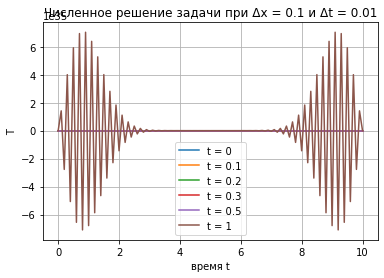

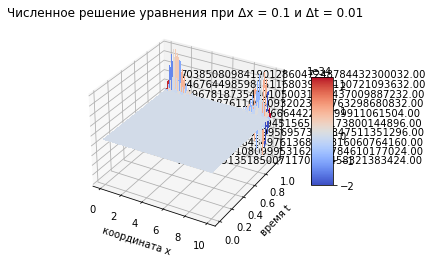

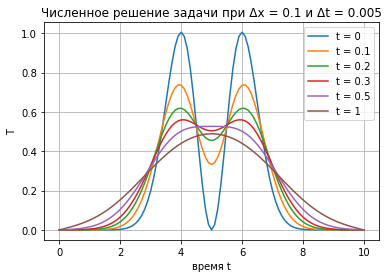

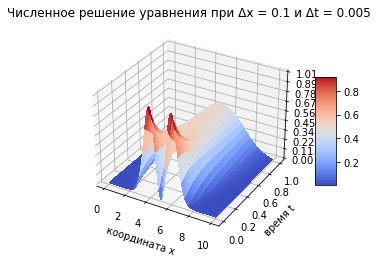

In [43]:
T = 1  # рассматриваемый временной промежуток
X = 10  # рассматриваемая область в пространстве

for Δx, Δt in [(0.1, 0.01), (0.1, 0.005)]:
    α = Δt / (Δx * Δx)
    J, N = int(X / Δx) + 1, int(T / Δt) + 1  # количество шагов по x и t
    u = np.zeros((J, N), np.float64)  # массив для решения задачи
    t = np.linspace(0, T, N, dtype=np.float64)  # сетка по времени
    x = np.linspace(0, X, J, dtype=np.float64)  # сетка по координатам

    u[:, 0] = (
        41 / 15 * (x - 5) * (x - 5) * np.exp(-(x - 5) * (x - 5))
    )  # заполняем начальные условия задачи
    u[0, 0] = 0  # граничное условие
    u[J - 1, 0] = 0  # граничное условие
    u = solve1(u, J, N, α)  # вызов функции численного расчёта по явной схеме
    graph(x, u, Δt, Δx)  # простроение графиков
    graph3D(x, t, u, Δt, Δx)  # простроение 3D графика

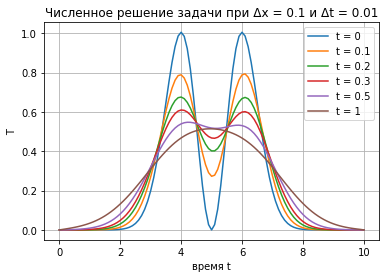

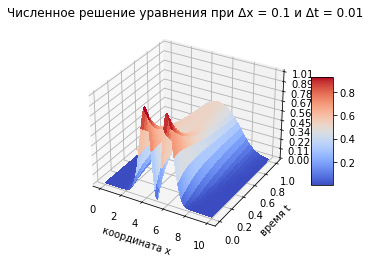

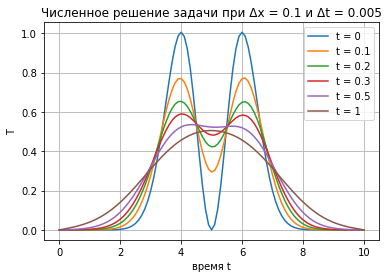

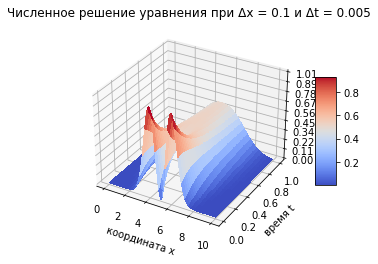

In [44]:
for Δx, Δt in [(0.1, 0.01), (0.1, 0.005)]:
    s = Δx * Δx / Δt
    J, N = int(X / Δx) + 1, int(T / Δt) + 1  # количество шагов по x и t
    u = np.zeros((J, N), np.float64)  # массив для решения задачи
    t = np.linspace(0, T, N, dtype=np.float64)  # сетка по времени
    x = np.linspace(0, X, J, dtype=np.float64)  # сетка по координатам

    u[:, 0] = (
        41 / 15 * (x - 5) * (x - 5) * np.exp(-(x - 5) * (x - 5))
    )  # заполняем начальные условия задачи
    u[0, 0] = 0  # граничное условие
    u[J - 1, 0] = 0  # граничное условие
    u = solve2(u, J, N, s)  # вызов функции численного расчёта по неявной схеме
    graph(x, u, Δt, Δx)  # простроение графиков
    graph3D(x, t, u, Δt, Δx)  # простроение 3D графика

C:\Users\maxsh\AppData\Local\Temp\ipykernel_12724\1190905401.py:9: RuntimeWarning: divide by zero encountered in true_divide
  (1 + 2 * α * (np.sin(Pi * xx / 2)) ** 2)


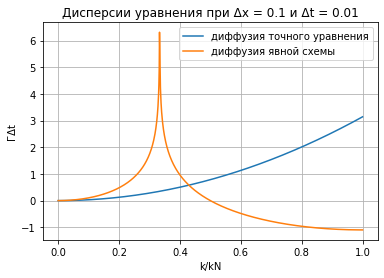

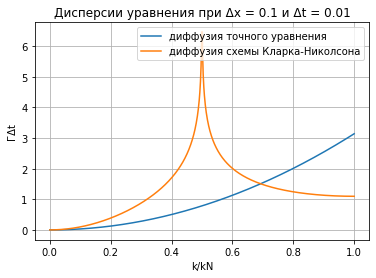

C:\Users\maxsh\AppData\Local\Temp\ipykernel_12724\1190905401.py:7: RuntimeWarning: divide by zero encountered in log
  num1 = -np.log(np.fabs(1 - 4 * α * (np.sin(Pi * xx / 2)) ** 2))


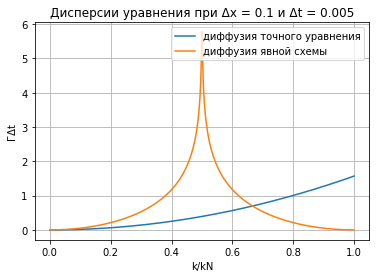

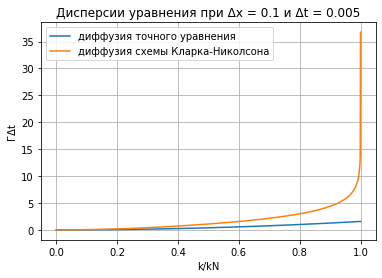

In [45]:
Pi = math.pi
# диффузия явной и неявной схем
for Δx, Δt in [(0.1, 0.01), (0.1, 0.005)]:
    α = Δt / (Δx * Δx)
    xx = np.linspace(0, 1, 1001)
    exact = Pi * α * xx**2
    num1 = -np.log(np.fabs(1 - 4 * α * (np.sin(Pi * xx / 2)) ** 2))
    num2 = np.log(
        (1 + 2 * α * (np.sin(Pi * xx / 2)) ** 2)
        / np.fabs(1 - 2 * α * (np.sin(Pi * xx / 2)) ** 2)
    )
    fig1, ax1 = plt.subplots()
    ax1.plot(xx, exact, label="диффузия точного уравнения")
    ax1.plot(xx, num1, label="диффузия явной схемы")
    ax1.set(
        xlabel="k/kN",
        ylabel="ГΔt",
        title="Дисперсии уравнения при Δx = " + str(Δx) + " и Δt = " + str(Δt),
    )
    ax1.grid()
    ax1.legend()

    fig2, ax2 = plt.subplots()
    ax2.plot(xx, exact, label="диффузия точного уравнения")
    ax2.plot(xx, num2, label="диффузия схемы Кларка-Николсона")
    ax2.set(
        xlabel="k/kN",
        ylabel="ГΔt",
        title="Дисперсии уравнения при Δx = " + str(Δx) + " и Δt = " + str(Δt),
    )
    ax2.grid()
    ax2.legend()
    plt.show()

c:\Users\maxsh\anaconda3\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
MovieWriter ffmpeg unavailable; using Pillow instead.


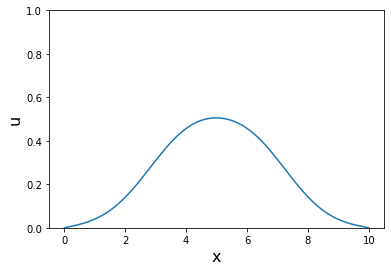

In [47]:
# анимация
fig, ax = plt.subplots()
ax.set_ylim(0, 1)
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16)
(line,) = ax.plot(x, u[..., 0])


def init():
    line.set_ydata([np.nan] * len(x))
    return (line,)


def animate(i):
    line.set_ydata(u[..., i])
    return (line,)


anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=N, interval=Δt
)
anim.save('видео.gif', fps=30)
plt.show()
